<a href="https://colab.research.google.com/github/stiwari-ds/DL-Simplified-SWOC-S3/blob/phishing-website-detection/Phishing-Website-Detection/Model/01_ml_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
#Utils
import gc
import os
import warnings

gc.enable()
warnings.filterwarnings(action='ignore')

#Data analysis
import numpy as np
import pandas as pd

#Visualization
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'png'

#Reproducibility
SEED = 2311
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

In [2]:
#modeling
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Data

**Cleaned data and feature sets (from [EDA notebook](https://github.com/stiwari-ds/DL-Simplified-SWOC-S3/blob/phishing-website-detection/Phishing-Website-Detection/Model/00_eda_and_preprocessing.ipynb))**

In [3]:
#data: cleaned version
DATA_URL = 'https://raw.githubusercontent.com/stiwari-ds/DL-Simplified-SWOC-S3/phishing-website-detection/Phishing-Website-Detection/Dataset/processed/phishing_website_dataset_cleaned.csv'
data = pd.read_csv(DATA_URL)

In [4]:
TARGET = 'result'

all_features = [f for f in data.columns if f != TARGET]

reduced_features = [
    f for f in all_features if f not in 
    ('favicon', 'submitting_to_email', 'redirect', 'right_click',
    'popup_window', 'iframe', 'links_pointing_to_page')
]

top_features = [
    'ssl_final_state', 'url_of_anchor', 'prefix_suffix', 
    'web_traffic', 'having_subdomain', 'links_in_tags', 
    'request_url', 'sfh', 'domain_registration_length'
]

# Modeling

In [5]:
model1 = LogisticRegression(C=0.1, max_iter=1000, random_state=SEED)

model2 = Pipeline([
    ('pca', PCA(n_components=0.95)),
    ('lr', LogisticRegression(C=0.1, max_iter=1000, random_state=SEED))
])

model3 = RandomForestClassifier(
    n_estimators=150, 
    max_depth=7, 
    n_jobs=-1,
    random_state=SEED
)

In [6]:
def evaluate(model, feature_set, seed, return_oof=False):
    cv_rocauc = []
    cv_acc = []
    oof_preds = {}

    X, y = data[feature_set], data[TARGET]
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        X_train, y_train = X.loc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.loc[val_idx], y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        val_probs = model.predict_proba(X_val)[:, 1]
        val_preds = model.predict(X_val)
        oof_preds.update(dict(zip(val_idx, val_preds)))
        
        cv_rocauc.append(roc_auc_score(y_val, val_probs))
        cv_acc.append(accuracy_score(y_val, val_preds))
    
    avg_acc = np.mean(cv_acc)
    avg_rocauc = np.mean(cv_rocauc)
    oof_preds = pd.Series(oof_preds).sort_index()
    
    if return_oof: 
        return avg_rocauc, avg_acc, oof_preds
    else: 
        return avg_rocauc, avg_acc

In [7]:
def run_experiment(model, feature_set, verbose=False, runs=10):
    training_seeds = np.random.randint(low=1, high=1e5, size=runs)
    
    all_rocauc = []
    all_acc = []
    for i, seed in enumerate(training_seeds):
        rocauc, acc = evaluate(model, feature_set, seed)
        all_rocauc.append(rocauc)
        all_acc.append(acc)
        if verbose:
            print(f'Run #{i+1:<2} [seed = {seed:<4}]: ' \
                  f'ROC-AUC = {rocauc:.4f}, Accuracy = {acc:.4f}')
        
    print(f'\nAverage over {runs} runs of 10-fold CV: ' \
          f'ROC-AUC = {np.mean(all_rocauc):.4f}+/-{np.std(all_rocauc):.4f}, ' \
          f'Accuracy = {np.mean(all_acc):.4f}+/-{np.std(all_acc):.4f}\n')

### 1. Model 1 + All features

In [8]:
run_experiment(model1, all_features, verbose=True, runs=3)

Run #1  [seed = 4127]: ROC-AUC = 0.9783, Accuracy = 0.9281
Run #2  [seed = 74863]: ROC-AUC = 0.9788, Accuracy = 0.9283
Run #3  [seed = 13464]: ROC-AUC = 0.9784, Accuracy = 0.9279

Average over 3 runs of 10-fold CV: ROC-AUC = 0.9785+/-0.0002, Accuracy = 0.9281+/-0.0001



In [9]:
%%time
run_experiment(model1, all_features)


Average over 10 runs of 10-fold CV: ROC-AUC = 0.9786+/-0.0001, Accuracy = 0.9281+/-0.0004

CPU times: user 17 s, sys: 15 s, total: 32.1 s
Wall time: 27.3 s


### 2. Model 1 + Reduced features

In [10]:
%%time
run_experiment(model1, reduced_features)


Average over 10 runs of 10-fold CV: ROC-AUC = 0.9769+/-0.0001, Accuracy = 0.9251+/-0.0003

CPU times: user 10.9 s, sys: 7.5 s, total: 18.4 s
Wall time: 9.57 s


### 3. Model 1 + Top features

In [11]:
%%time
run_experiment(model1, top_features)


Average over 10 runs of 10-fold CV: ROC-AUC = 0.9741+/-0.0001, Accuracy = 0.9205+/-0.0003

CPU times: user 5.82 s, sys: 4.36 s, total: 10.2 s
Wall time: 5.31 s


### 4. Model 2 + All features

In [12]:
%%time
run_experiment(model2, all_features)


Average over 10 runs of 10-fold CV: ROC-AUC = 0.9774+/-0.0000, Accuracy = 0.9245+/-0.0005

CPU times: user 11.5 s, sys: 14.1 s, total: 25.6 s
Wall time: 13.4 s


### 5. Model 2 + Reduced features

In [13]:
%%time
run_experiment(model2, reduced_features)


Average over 10 runs of 10-fold CV: ROC-AUC = 0.9767+/-0.0001, Accuracy = 0.9238+/-0.0002

CPU times: user 9.78 s, sys: 11.2 s, total: 20.9 s
Wall time: 10.9 s


### 6. Model 2 + Top features

In [14]:
%%time
run_experiment(model2, top_features)


Average over 10 runs of 10-fold CV: ROC-AUC = 0.9738+/-0.0001, Accuracy = 0.9212+/-0.0004

CPU times: user 7.06 s, sys: 9.7 s, total: 16.8 s
Wall time: 10.2 s


### 7. Model 3 + All features

In [15]:
%%time
run_experiment(model3, all_features)


Average over 10 runs of 10-fold CV: ROC-AUC = 0.9872+/-0.0002, Accuracy = 0.9384+/-0.0006

CPU times: user 1min 58s, sys: 8.52 s, total: 2min 6s
Wall time: 1min 23s


### 8. Model 3 + Reduced features

In [16]:
%%time
run_experiment(model3, reduced_features)


Average over 10 runs of 10-fold CV: ROC-AUC = 0.9868+/-0.0001, Accuracy = 0.9385+/-0.0007

CPU times: user 1min 52s, sys: 7.88 s, total: 2min
Wall time: 1min 19s


### 9. Model 3 + Top features

In [17]:
%%time
run_experiment(model3, top_features)


Average over 10 runs of 10-fold CV: ROC-AUC = 0.9859+/-0.0001, Accuracy = 0.9363+/-0.0006

CPU times: user 1min 44s, sys: 7.75 s, total: 1min 52s
Wall time: 1min 14s


# Results analysis

### 1. Logistic Regression

In [18]:
lr = LogisticRegression(C=0.1, max_iter=1000, random_state=SEED)

lr_rocauc, lr_acc, lr_oof = evaluate(lr, all_features, seed=SEED, return_oof=True)

In [19]:
print(f'ROC-AUC = {lr_rocauc:.4f}, Accuracy = {lr_acc:.4f}')

ROC-AUC = 0.9786, Accuracy = 0.9288


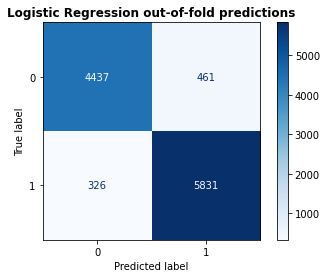

In [20]:
lr_cm = ConfusionMatrixDisplay.from_predictions(data[TARGET], lr_oof, cmap='Blues')
lr_cm.ax_.set_title('Logistic Regression out-of-fold predictions',
                    fontweight='bold', fontsize=12, ha='center')
plt.savefig(fname='logistic-regression-confusion-matrix.png', bbox_inches='tight')
plt.show()

### 2. PCA + Logistic Regression

In [21]:
pcalr = Pipeline([
    ('pca', PCA(n_components=0.95)),
    ('lr', LogisticRegression(C=0.1, max_iter=1000, random_state=SEED))
])

pcalr_rocauc, pcalr_acc, pcalr_oof = evaluate(pcalr, all_features, seed=SEED, return_oof=True)

In [22]:
print(f'ROC-AUC = {pcalr_rocauc:.4f}, Accuracy = {pcalr_acc:.4f}')

ROC-AUC = 0.9773, Accuracy = 0.9243


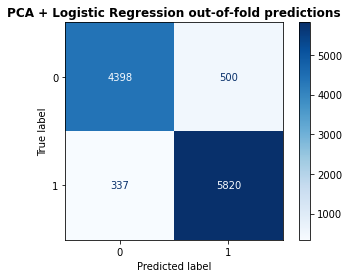

In [23]:
pcalr_cm = ConfusionMatrixDisplay.from_predictions(data[TARGET], pcalr_oof, cmap='Blues')
pcalr_cm.ax_.set_title('PCA + Logistic Regression out-of-fold predictions',
                        fontweight='bold', fontsize=12, ha='center')
plt.savefig(fname='pca-logistic-regression-confusion-matrix.png', bbox_inches='tight')
plt.show()

### 3. RandomForestClassifier

In [24]:
rf = RandomForestClassifier(
    n_estimators=150, 
    max_depth=7, 
    n_jobs=-1,
    random_state=SEED
)

rf_rocauc, rf_acc, rf_oof = evaluate(rf, all_features, seed=SEED, return_oof=True)

In [25]:
print(f'ROC-AUC = {rf_rocauc:.4f}, Accuracy = {rf_acc:.4f}')

ROC-AUC = 0.9872, Accuracy = 0.9377


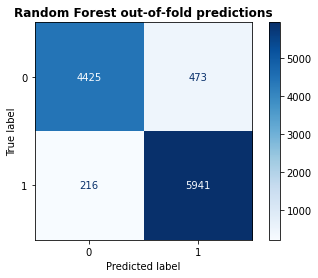

In [26]:
rf_cm = ConfusionMatrixDisplay.from_predictions(data[TARGET], rf_oof, cmap='Blues')
rf_cm.ax_.set_title('Random Forest out-of-fold predictions',
                    fontweight='bold', fontsize=12, ha='center')
plt.savefig(fname='random-forest-confusion-matrix.png', bbox_inches='tight')
plt.show()

Random Forest was able to make a significant improvement on false-negatives.

# Summary

* We tried three ML models for binary classification: 
    1. Logistic Regression (LR)
    2. Principal Component Analysis + Logistic Regression pipeline (PCA-LR)
    3. RandomForestClassifier (RF)

* All three models show very small drop in accuracy (maximum of 0.7% for LR) even when feature set is reduced by 70% (30 -> 9), with the training time getting shorter. 
* PCA-LR shows consistent performance since components have variance in decreasing order so most of the information is captured by the first few components. RF also shows no significant drop in performance since it is able to utilize the informative features better, compared to a linear model like LR.
* Thus, we can prioritize working with a smaller feature set first and see if it is enough to outperform these models. The reduction in training time might be more valuable for fitting a complex model like a neural network as compared to these simple models.
* **When modeling with neural networks, we should be aiming to beat this baseline performance: AUC $\approx$ 0.987 and Accuracy $\approx$ 93.8%**